# Sentiment Analysis

This workbook presents a variation of basic sentiment analysis that follows the treebank approach modelled at https://nlp.stanford.edu/sentiment/. 

The dataset includes a list of sentences that have been pulled from the Rotten Tomatoes movie review site and scored for sentiment as follows:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

Each root sentence has also been parsed into a phrase tree, with the component phrases scored and included in the training data. This model is intended to improve the classic "bag-of-words" approach, which has difficulty classifying longer and more complex sentences due to issues like the scope of negation, etc.  


## 1. Data Exploration

The full dataset has been split into train and test sets (available at https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews) which are stored in a tab-delimited file (.tsv). For this workbook I will fit and evaluate models using only the train set since the test set lacks labels.

First, I will load the data into a pandas dataframe.

In [1]:
%matplotlib inline
import pandas as pd
data = pd.read_csv('./data/train.tsv', delimiter="\t")

As shown below, the train set includes 156060 phrases that compose 8529 distinct sentences.

In [2]:
data.shape

(156060, 4)

In [3]:
data['SentenceId'].nunique()

8529

The following function will add a column **N** to the dataframe that measures the length of the phrase in number of words.

In [6]:
import nltk
from nltk import RegexpTokenizer
def n_grams(phrase):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    words = tokenizer.tokenize(phrase)
    return len(words)

data['N'] = data['Phrase'].apply(n_grams)

The following histogram shows the distribution of phrase lengths in the dataset. The minimum length is 1 (individual words) while the maximum length is 48.

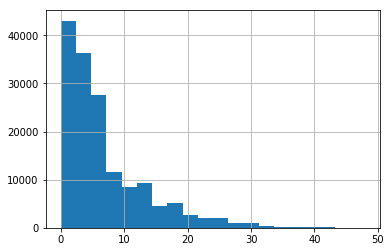

In [7]:
data['N'].hist(bins = 20)

The sentences themselves also vary in length, though surprisingly there are 47 sentences that are only one-word long.

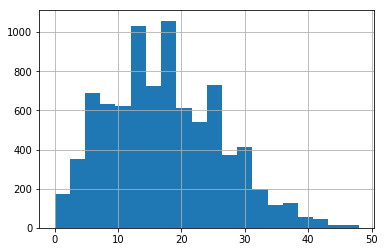

In [8]:
sentences = data.groupby(['SentenceId']).first().reset_index()
sentences['N'].hist(bins = 20)

Several of these appear to be mistakes in which the full sentence has not been preserved in the dataset, as with dentence 694 shown below. These data quality issues will obviously affect the accuracy of our model, but I am not going to take the time to clean it up for the purposes of this example.

In [10]:
data.loc[(data['SentenceId'] == 694)]

,PhraseId,SentenceId,Phrase,Sentiment,N
16123,16124,694,moved,3,1
16124,16125,694,the emotional tumult,1,3
16125,16126,694,emotional tumult,2,2
16126,16127,694,tumult,2,1
16127,16128,694,depends a lot on how interesting and likable y...,2,11
16128,16129,694,depends a lot on how interesting and likable y...,3,11
16129,16130,694,depends,2,1
16130,16131,694,a lot on how interesting and likable you find ...,2,10
16131,16132,694,on how interesting and likable you find them,2,8
16132,16133,694,how interesting and likable you find them,2,7


The full data for sentence 17 below illustrates the proper division of phrases.

In [147]:
data.loc[(data['SentenceId'] == 17)]

,PhraseId,SentenceId,Phrase,Sentiment,N
458,459,17,"a bilingual charmer , just like the woman who ...",3,10
459,460,17,"a bilingual charmer ,",3,3
460,461,17,a bilingual charmer,3,3
461,462,17,bilingual charmer,3,2
462,463,17,bilingual,2,1
463,464,17,charmer,3,1
464,465,17,just like the woman who inspired it,2,7
465,466,17,like the woman who inspired it,2,6
466,467,17,the woman who inspired it,2,5
467,468,17,the woman,2,2


I have hand coded this sentence using the NLTK.Tree structure and using the sentiment labels as the nodes to visualize the sentence structure below.

In [19]:
from nltk import Tree
sent =  "(3 (3 a (3 (2 bilingual) (3 charmer ))) (2 just (2 like (2 (2 the (2 woman )) (2 (2 who ) (2 (3 inspired ) it ))))))"
tree = Tree.fromstring(sent)
tree.pretty_print()

                     3                                                
         ____________|__________                                       
        |                       2                                     
        |                   ____|_____________                         
        |                  |                  2                       
        |                  |     _____________|____                    
        |                  |    |                  2                  
        |                  |    |         _________|___                
        3                  |    |        |             2              
  ______|______            |    |        |          ___|___            
 |             3           |    |        2         |       2          
 |       ______|_____      |    |     ___|____     |    ___|_____      
 |      2            3     |    |    |        2    2   |         3    
 |      |            |     |    |    |        |    |   |         |     

As is the case with the preceding example, the following histogram shows that about 80,000 phrases have been given a neutral score of 2, while the scores 0 and 4 have been appplied to less than 10,000 phrases each.

Sentiment
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Sentiment, dtype: object

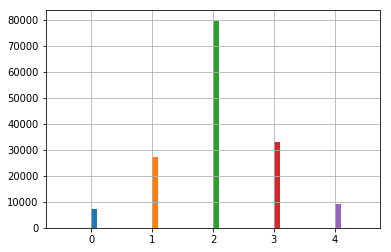

In [20]:
data.groupby(['Sentiment'])['Sentiment'].hist()

## 2. Baseline "Bag of Words" Approach

Before analyzing the full dataset, I will demonstrate the limitations of the basic "Bag of Words" approach using only the root sentences, which were added to the **sentences** dataframe above.

### 2.1. Train-Test Split

Because it will be important to keep the subphrases together with their root sentences in the full analysis, I am going to simply split the data 80/20 based on the **SentenceId** rather than creating a randomized split. 

In [21]:
s_train = sentences.loc[sentences['SentenceId'] <= 6824]
s_test = sentences.loc[sentences['SentenceId'] > 6824]

### 2.2. Preprocessing

Preprocessing language data typically involves tokenizing sentences into words, normalizing the words (converting to lower case, etc.), and removing punctuation and stop words. The **CountVectorizer** provided by scikit-learn feature_extraction.text will first perform tokenization and normaliztion and then convert each phrase into a word vector with each word in the corpus represented by a unique integer id. Note that the CountVectorizer should be fit on the train set to avoid leakage. 

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
s_cv = CountVectorizer()
s_cv.fit(s_train['Phrase'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### 2.3. Multinomial Logistic Regression

I will use the **LogisticRegression** model provided by scikit-learn for the sentiment analysis. 

In [27]:
from sklearn.linear_model import LogisticRegression

x = s_cv.transform(s_train['Phrase'])
X = s_cv.transform(s_test['Phrase']) 
y = s_train['Sentiment'].values 
Y = s_test['Sentiment'].values 

s_clf = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial')
s_clf.fit(x, y)
Y_hat = s_clf.predict(X)

We can score the model for accuracy using **accuracy_score** from scikit-learn. You will note that this model using only the root sentences scores about 39%.

In [28]:
from sklearn.metrics import accuracy_score
print accuracy_score(Y, Y_hat)

0.3865889212827988


## 3. Sentiment Tree Analysis

The full Rotten Tomatoes movie review dataset does not only include labels for the root sentences, but also for each component phrase in the underlying phrase tree analysis. Adding these subphrases improves the model by retaining information about the underlying grammatical structure rather than simply using a list of words.

### 3.1. Train-Test Split

Again, in order to keep the component phrases together with their root sentence, I will split the dataset 80/20 based on **SentenceId**. 

In [30]:
train = data.loc[data['SentenceId'] <= 6824]
test = data.loc[data['SentenceId'] > 6824]

### 3.2. Preprocessing

Next I will fit the **count vectorizer** provided in the scikit-learn **feature_extraction** class using the train portion of the full dataset.

In [31]:
cv = CountVectorizer()
cv.fit(train['Phrase'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### 3.3 Multinomial Logistic Regression

I will again use the **LogisticRegression** model provided by scikit-learn for prediction.

In [33]:
x = cv.transform(train['Phrase'])
X = cv.transform(test['Phrase']) 
y = train['Sentiment'].values 
Y = test['Sentiment'].values 

clf = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial')
clf.fit(x, y)
Y_hat = clf.predict(X)

I will add the predicted values to the test data as a new column in order to analyze the accuracy of the new model on different sub groups of data.

In [38]:
test = pd.DataFrame(test)
test['Pred'] = Y_hat
test.head()

,PhraseId,SentenceId,Phrase,Sentiment,N,Pred
126947,126948,6825,"Such a fine idea for a film , and such a stult...",1,13,1
126948,126949,6825,"Such a fine idea for a film , and such a stult...",2,11,4
126949,126950,6825,Such a fine idea,4,4,3
126950,126951,6825,a fine idea,3,3,3
126951,126952,6825,fine idea,3,2,3


First, the overall accuracy for the full dataset is approximately 59%.

In [36]:
print accuracy_score(test['Sentiment'], test['Pred'])

0.592037921203586


Remember, however, that the full dataset includes all of the sub phrases along with the root sentences. The following code will subcategorize the accuracy based on the number of words (**N**) in the phrase. 

In [39]:
results = []
for n in range(1,49): 
    Y = test.loc[test['N'] <= n]['Sentiment'].values 
    Y_hat = test.loc[test['N'] <= n]['Pred'].values 
    results.append(accuracy_score(Y, Y_hat))

The following plot shows that the accuracy of the model decreases as the maximum phrase size increases. In other words, the model has a much more difficult time classifying longer phrases. 

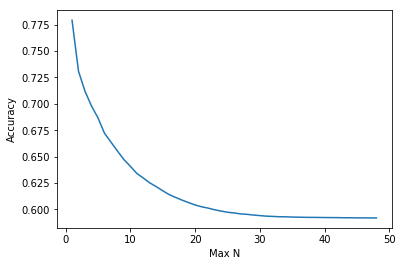

In [40]:
import matplotlib.pyplot as plt
x = range(1,49)
plt.plot(x,results)
plt.ylabel('Accuracy')
plt.xlabel('Max N')
plt.show()

The following code isolates the root sentences and calculates the score of the new model for comparison with the baseline "bag of words" approach. This shows that accuracy has improved from approximately 39% to 41% for the root sentences. 

In [42]:
s_test = test.groupby(['SentenceId']).first().reset_index()
s_Y = s_test['Sentiment']
s_Y_hat = s_test['Pred']
print accuracy_score(s_Y, s_Y_hat)

0.4110787172011662
